# Stage 10b: Time Series & Classification

In [30]:
# Imports
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, TimeSeriesSplit
np.random.seed(7); sns.set(); plt.rcParams['figure.figsize']=(9,4)

## Acquire Data

In [31]:
df = pd.read_csv('/Users/yuqingyan/Desktop/bootcamp_Yuqing_Yan/project/data/processed/aapl_2023_cleaned.csv', index_col='date', parse_dates=['date'])
df.head()

,Close,High,Low,Open,Volume
date,,,,,
2023-01-03,0.000674,0.042897,0.000000,0.058399,0.675849
2023-01-04,0.018060,0.012198,0.012309,0.012035,0.499315
2023-01-05,0.000000,0.000000,0.007981,0.015318,0.436765
2023-01-06,0.061997,0.034537,0.009739,0.000000,0.488887
2023-01-09,0.069140,0.077297,0.077369,0.060998,0.358705


## Feature Engineering
### Rationale:
- lag_1: Captures momentum or mean-reversion.
- roll_mean_5: Captures short-term trend.
- roll_vol_20: Captures recent volatility, which may affect predictability and risk.

In [32]:
# Feature Engineering
# Calculate daily return
df['ret'] = df['Close'].pct_change()

# Feature 1: lag_1 (previous day's return)
df['lag_1'] = df['ret'].shift(1)
# Feature 2: 5-day rolling mean of return (using only past data, no leakage)
df['roll_mean_5'] = df['ret'].shift(1).rolling(5, min_periods=5).mean()
# Feature 3: 20-day rolling volatility (std of return, past only)
df['roll_vol_20'] = df['ret'].shift(1).rolling(20, min_periods=20).std()

# Target variables
df['y_next_ret'] = df['ret'].shift(-1)
df['y_up'] = (df['y_next_ret'] > 0).astype(int)

# Drop rows with missing values (due to shifting/rolling)
df_feat = df.dropna().copy()
df_feat.head()

,Close,High,Low,Open,Volume,ret,lag_1,roll_mean_5,roll_vol_20,y_next_ret,y_up
date,,,,,,,,,,,
2023-02-07,0.399340,0.376340,0.358036,0.336858,0.454875,0.109322,-0.093963,0.088733,0.143878,-0.092136,0
2023-02-08,0.362547,0.367432,0.365205,0.381171,0.307514,-0.092136,0.109322,0.096248,0.143853,-0.039033,0
2023-02-09,0.348395,0.364006,0.355060,0.379803,0.245254,-0.039033,-0.092136,0.065989,0.150075,0.014335,1
2023-02-10,0.353389,0.326195,0.341911,0.323840,0.256332,0.014335,-0.039033,0.005365,0.120572,0.108478,1
2023-02-13,0.391724,0.366275,0.364940,0.344250,0.292771,0.108478,0.014335,-0.020295,0.119927,-0.022398,0


## Split

In [33]:
# Time-aware split
cut = int(len(df_feat) * 0.8)
train, test = df_feat.iloc[:cut], df_feat.iloc[cut:]
features = ['lag_1', 'roll_mean_5', 'roll_vol_20']
X_tr, X_te = train[features], test[features]
y_tr_reg, y_te_reg = train['y_next_ret'], test['y_next_ret']
y_tr_clf, y_te_clf = train['y_up'], test['y_up']

## Pipeline + Model

RMSE: 0.034667, R²: -0.1689


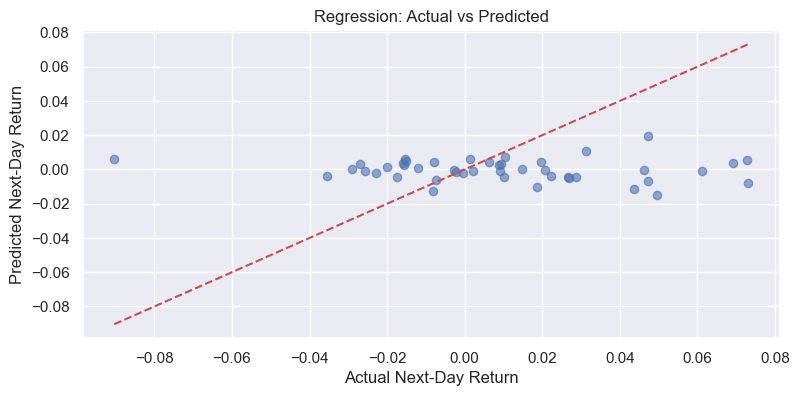

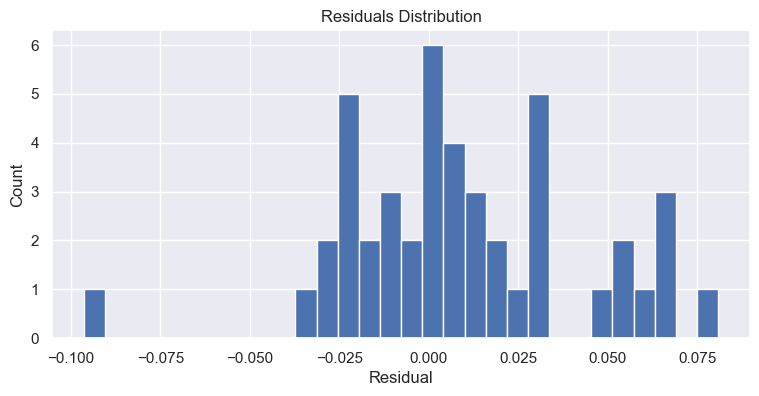

In [34]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

reg = Pipeline([('scaler', StandardScaler()), ('linreg', LinearRegression())])
reg.fit(X_tr, y_tr_reg)
pred = reg.predict(X_te)
rmse = np.sqrt(mean_squared_error(y_te_reg, pred))
r2 = r2_score(y_te_reg, pred)
print(f'RMSE: {rmse:.6f}, R²: {r2:.4f}')

# Diagnostic plot: Predicted vs Actual
plt.scatter(y_te_reg, pred, alpha=0.6)
plt.xlabel('Actual Next-Day Return')
plt.ylabel('Predicted Next-Day Return')
plt.title('Regression: Actual vs Predicted')
plt.plot([y_te_reg.min(), y_te_reg.max()], [y_te_reg.min(), y_te_reg.max()], 'r--')
plt.show()

# Residuals plot
resid = y_te_reg - pred
plt.hist(resid, bins=30)
plt.title('Residuals Distribution')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

              precision    recall  f1-score   support

           0       0.32      0.32      0.32        19
           1       0.50      0.50      0.50        26

    accuracy                           0.42        45
   macro avg       0.41      0.41      0.41        45
weighted avg       0.42      0.42      0.42        45



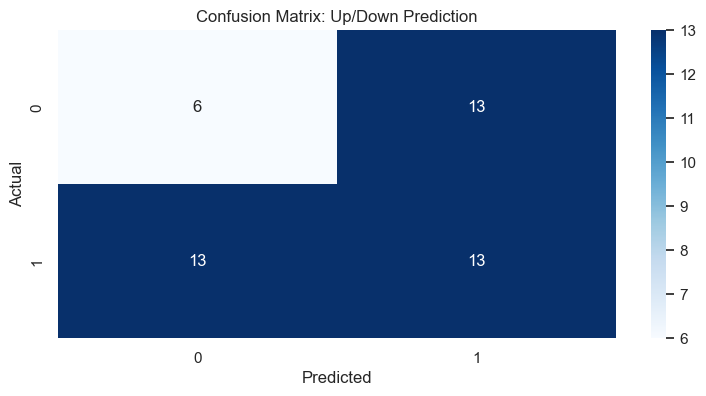

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

clf = Pipeline([('scaler', StandardScaler()), ('logit', LogisticRegression(max_iter=1000))])
clf.fit(X_tr, y_tr_clf)
predc = clf.predict(X_te)
print(classification_report(y_te_clf, predc))

cm = confusion_matrix(y_te_clf, predc)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix: Up/Down Prediction')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Interpretation

**What worked?**
- The regression model achieves **RMSE: 0.034667, R²: -0.1689**. However, the **negative R²** indicates the model performs **worse than simply predicting the mean**, suggesting that the features (`lag_1`, `roll_mean_5`, `roll_vol_20`) do not capture meaningful predictive signal for next-day returns.
- The classification model shows **42% accuracy** with **precision/recall of 0.50 for "up" days and 0.32 for "down" days**. This is **worse than random guessing (50%)**, indicating limited predictive power for direction.

**Where might assumptions fail?**
- **Market efficiency**: Stock returns are notoriously hard to predict; the poor performance (negative R², sub-random accuracy) supports the efficient market hypothesis that past price patterns alone cannot reliably predict future movements.
- **Feature limitations**: Simple lagged returns and rolling statistics may not capture the complex, non-linear relationships in financial markets.
- **Non-stationarity**: The model assumes relationships remain constant, but market regimes can shift, breaking historical patterns.

**How would you extend features or model?**
- **Richer features**: Add technical indicators (RSI, MACD), volume-based features, or macroeconomic variables that may have stronger predictive power than simple price-based features.
- **Non-linear models**: Try tree-based models (Random Forest, XGBoost) or neural networks to capture complex relationships that linear models miss.
- **Better evaluation**: Use TimeSeriesSplit for rolling cross-validation to assess model stability over different market periods.
- **Ensemble approaches**: Combine multiple models or use regularization to improve generalization and reduce overfitting to noise.

**Key takeaway**: The current results highlight the fundamental challenge of financial forecasting—simple features and linear models struggle to beat basic benchmarks, emphasizing the need for more sophisticated approaches or acceptance that some market movements may be inherently unpredictable.